In [1]:
import warnings
warnings.simplefilter(action='ignore')
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df_all = pd.read_xml("/content/drive/MyDrive/CEM538_project2/2022-02260 Requester Copy.xml",encoding='latin1')

In [10]:
df_all[df_all['ESTABLISHMENT_ID']=="AROMA EXPRESSO BAR"].head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED


In [40]:
#df_all.nunique()

ROW_ID                         733495
ESTABLISHMENT_ID                36378
INSPECTION_ID                  460633
ESTABLISHMENT_NAME              25938
ESTABLISHMENTTYPE                  59
ESTABLISHMENT_ADDRESS           15227
LATITUDE                        14259
LONGITUDE                       14403
ESTABLISHMENT_STATUS                4
MINIMUM_INSPECTIONS_PERYEAR         3
INFRACTION_DETAILS                953
INSPECTION_DATE                  6432
SEVERITY                            4
ACTION                             14
COURT_OUTCOME                      12
AMOUNT_FINED                      293
dtype: int64

In [11]:
def check_inspection(df,id):
  df_of_id = df.loc[df.ESTABLISHMENT_ID == id] #All the inspection result of facility with establishment ID of "id"
  if(df_of_id.INFRACTION_DETAILS.isna().sum() == df_of_id.shape[0]): #Nan means no infraction observed, if the amount of nan = number of inspections, that means the facility is clean all the time
      return False
  return True

#df_of_id = df_all.loc[df_all.ESTABLISHMENT_ID == 1222807] #All the inspection result of facility with establishment ID of "id"
#print(df_of_id.INFRACTION_DETAILS.isna().sum())
#print(df_of_id.shape[0])

In [12]:
unique_facility = df_all[['ESTABLISHMENT_ID','ESTABLISHMENT_NAME']].drop_duplicates(subset=['ESTABLISHMENT_ID'])
unique_facility = unique_facility.set_index('ESTABLISHMENT_ID')
unique_facility.head() #create a dataframe containing only the facility name and their ID

,ESTABLISHMENT_NAME
ESTABLISHMENT_ID,
1222579,SAI-LILA KHAMAN DHOKLA HOUSE
1222580,OYINGBO AFRICAN SUPERMARKET
1222807,PHO BO TO
1222984,SLAKE YOUR THIRST
1223056,PIZZA PIZZA


In [13]:
#Create a column INFRACTION indicating that wether a facility has infraction
unique_facility_result = unique_facility.copy()
unique_facility_result['INFRACTION'] = unique_facility_result.apply(lambda row: check_inspection(df_all,row.name), axis=1) 

In [14]:
unique_facility_result['ESTABLISHMENT_NAME'] = unique_facility_result['ESTABLISHMENT_NAME'].str.upper()
unique_facility_result.head(8)

,ESTABLISHMENT_NAME,INFRACTION
ESTABLISHMENT_ID,,
1222579,SAI-LILA KHAMAN DHOKLA HOUSE,True
1222580,OYINGBO AFRICAN SUPERMARKET,True
1222807,PHO BO TO,True
1222984,SLAKE YOUR THIRST,False
1223056,PIZZA PIZZA,True
1223201,MARINOVA ANGUELOVA DANIELA,False
1223225,MR FINE FOODS CATERING TRUCK,False
1223438,RAINBOW CINEMAS,True


In [41]:
#unique_facility_result[unique_facility_result['INFRACTION']==True].count()

ESTABLISHMENT_NAME    28021
INFRACTION            28022
dtype: int64

In [15]:
#Split the name of restaurant into words, creating a list of all words in restaurant names
word_split = unique_facility_result['ESTABLISHMENT_NAME'].str.split('-| ',expand=True)

# Replace all special characters with ""
word_split = word_split.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '') 

# Reset indexes and column names
word_split = word_split.stack().reset_index().set_index('ESTABLISHMENT_ID')
word_split.columns = ['NUM','WORD']

#Remove empty strings
word_split = word_split[word_split['WORD'] != ""] 

In [16]:
word_split.head(10)

,NUM,WORD
ESTABLISHMENT_ID,,
1222579,0,SAI
1222579,1,LILA
1222579,2,KHAMAN
1222579,3,DHOKLA
1222579,4,HOUSE
1222580,0,OYINGBO
1222580,1,AFRICAN
1222580,2,SUPERMARKET
1222807,0,PHO


In [17]:
#Mark the restaurant with their infraciton results.
word_split_with_infraction = pd.merge(word_split,unique_facility_result['INFRACTION'],how='left',left_index=True,right_index=True)

In [18]:
word_split_with_infraction[word_split_with_infraction['WORD'] == 'AROMA']

,NUM,WORD,INFRACTION
ESTABLISHMENT_ID,,,
9421922,0,AROMA,True
10335240,0,AROMA,True
10375223,2,AROMA,True
10375684,0,AROMA,True
10377681,0,AROMA,True
...,...,...,...
10680469,0,AROMA,True
10687619,0,AROMA,True
10726303,0,AROMA,True


In [19]:
# A function that takes a word as input and returns the infraction rate when that word is in a facilities' name
def infraction_rate(df,word):
  all_with_word = df[df['WORD'] == word]
  total = all_with_word.shape[0] #This is the count of all the facilities having the word "word" in its name
  infraction_count = all_with_word[all_with_word['INFRACTION'] == True].shape[0] #This is the count of all the facilities having the word "word" in its name and have an infraction
  return infraction_count/total

In [20]:
# A function that takes a word as input and returns the count of word
def count_words(df,word):
  all_with_word = df[df['WORD'] == word]
  return all_with_word.shape[0]

In [21]:
all_words = word_split.drop_duplicates(subset='WORD')
all_words = all_words.reset_index()[['NUM','WORD']]

In [22]:
all_words.head(20)

,NUM,WORD
0,0,SAI
1,1,LILA
2,2,KHAMAN
3,3,DHOKLA
4,4,HOUSE
5,0,OYINGBO
6,1,AFRICAN
7,2,SUPERMARKET
8,0,PHO
9,1,BO


In [23]:
all_words_with_rate = all_words.copy()
all_words_with_rate['INFRACTION_RATE'] = all_words.apply(lambda row: infraction_rate(word_split_with_infraction,row.WORD), axis=1)

In [24]:
all_words_with_rate['NUM'] = all_words_with_rate.apply(lambda row: count_words(word_split_with_infraction, row.WORD), axis=1)

In [25]:
all_words_with_rate.head(50)

,NUM,WORD,INFRACTION_RATE
0,7,SAI,1.000000
1,1,LILA,1.000000
2,1,KHAMAN,1.000000
3,1,DHOKLA,1.000000
4,676,HOUSE,0.859467
5,1,OYINGBO,1.000000
6,43,AFRICAN,0.720930
7,191,SUPERMARKET,0.853403
8,153,PHO,0.895425
9,17,BO,0.941176


In [27]:
#Drop words in name that occured less than 30 times
all_words_rate_final = all_words_with_rate[all_words_with_rate['NUM'] > 80]
all_words_rate_final = all_words_rate_final.sort_values(by='INFRACTION_RATE',ascending=False)
#all_words_rate_final.head(50)
#print(all_words_rate_final.shape[0])

In [28]:
print(all_words_rate_final.mean())

NUM                241.666667
INFRACTION_RATE      0.745863
dtype: float64


In [29]:
print(all_words_rate_final[all_words_rate_final['WORD']=='AROMA'])

Empty DataFrame
Columns: [NUM, WORD, INFRACTION_RATE]
Index: []


In [30]:
all_words_rate_final.to_csv('all_words_rate_final.csv',index=False)

Text(0.5, 1.0, 'Rate of Infraction / Words in Facility Name (Top 10)')

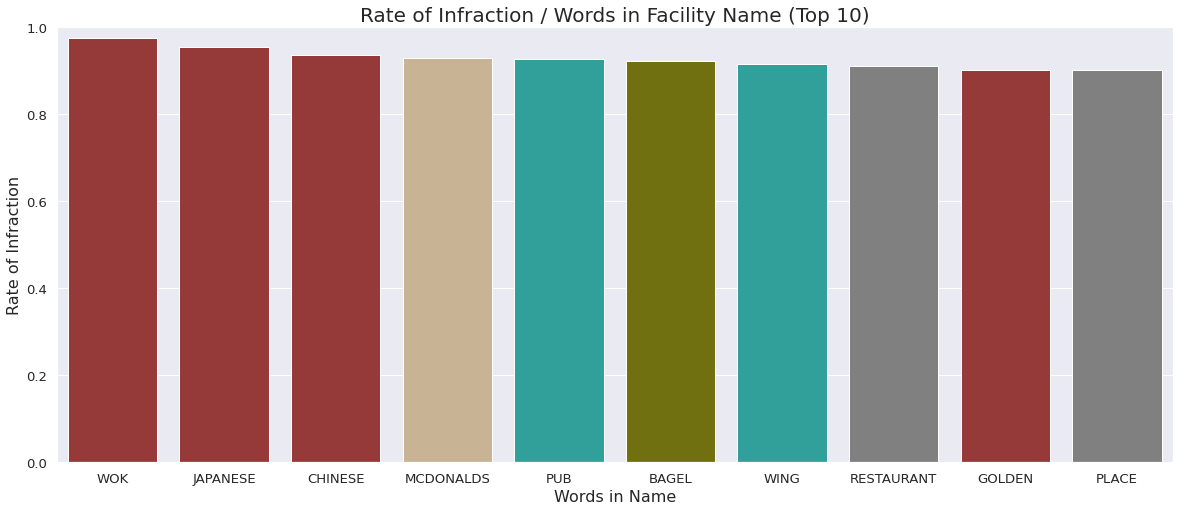

In [43]:
fig, axs = plt.subplots(nrows=1, figsize=(20, 8))
sns.set(font_scale=1.2)
cls = ['brown','brown','brown','tan','lightseagreen','olive','lightseagreen','grey','brown','grey']

sns.barplot(
    x='WORD',
    y='INFRACTION_RATE',
    data=all_words_rate_final.head(10),
    ci=None,
    dodge=True, 
    palette = cls  
)
axs.set(ylim=(0, 1))



plt.xlabel('Words in Name', fontsize=16);
plt.ylabel('Rate of Infraction', fontsize=16);
plt.title('Rate of Infraction / Words in Facility Name (Top 10)', fontsize=20)

In [32]:
all_words_rate_final[all_words_rate_final['WORD']=="GRILL"].head()

,NUM,WORD,INFRACTION_RATE
178,783,GRILL,0.869732


In [33]:
all_words_rate_ascending = all_words_rate_final.sort_values(by='INFRACTION_RATE',ascending=True)
all_words_rate_ascending = all_words_rate_ascending[all_words_rate_ascending['INFRACTION_RATE']!=0]

Text(0.5, 1.0, 'Words in Facility Name vs. Infraction Rate')

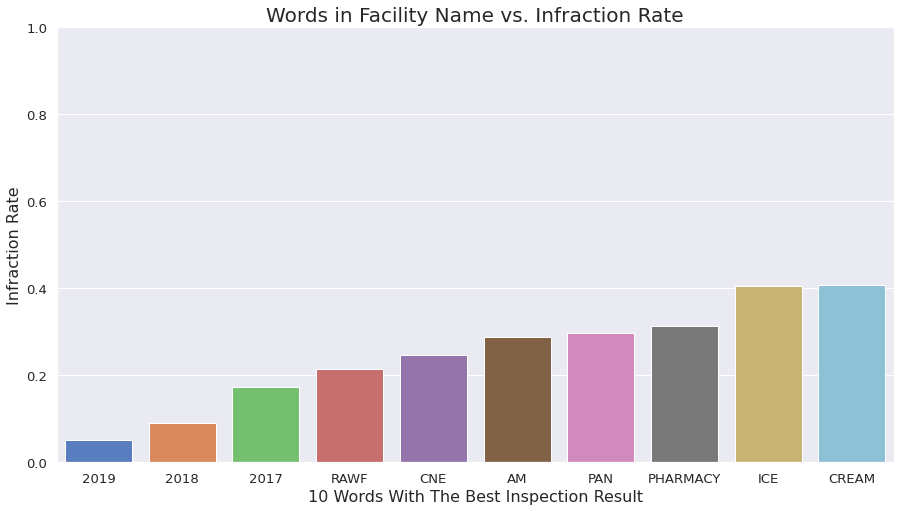

In [34]:
fig, axs = plt.subplots(nrows=1, figsize=(15, 8))
sns.set(font_scale=1.2)
sns.barplot(
    x='WORD',
    y='INFRACTION_RATE',
    data=all_words_rate_ascending.head(10),
    ci=None,
    palette = 'muted'
)
axs.set(ylim=(0, 1))
plt.xlabel('10 Words With The Best Inspection Result', fontsize=16);
plt.ylabel('Infraction Rate', fontsize=16);
plt.title('Words in Facility Name vs. Infraction Rate', fontsize=20)

In [35]:
#Perform the same steps with restaurant facilities only (Food Take Out, Restaurant, Cafeteria, Bakery, Food Court Vendor,
# Banquet Facility, Cafeteria - Public Access, Ice Cream / Yogurt Vendors,Cocktail Bar / Beverage Room
# Bake Shop,Hot Dog Cart,Mobile Food Preparation Premises, Bed & Breakfast, Catering Vehicle, Food Cart
# Farmers` Market Vendor
public_food_list = ['Food Take Out','Restaurant','Cafeteria','Bakery','Food Court Vendor','Banquet Facility','Cafeteria - Public Access',
                    'Ice Cream / Yogurt Vendors','Cocktail Bar / Beverage Room','Bake Shop','Hot Dog Cart','Mobile Food Preparation Premises',
                    'Bed & Breakfast','Catering Vehicle','Food Cart','Farmers` Market Vendor']

In [37]:
unique_restaurant = df_all[['ESTABLISHMENT_ID','ESTABLISHMENT_NAME','ESTABLISHMENTTYPE']].drop_duplicates(subset=['ESTABLISHMENT_ID'])
unique_restaurant = unique_restaurant[unique_restaurant.ESTABLISHMENTTYPE.isin(public_food_list)]
unique_restaurant = unique_restaurant[['ESTABLISHMENT_ID','ESTABLISHMENT_NAME']].set_index('ESTABLISHMENT_ID')
unique_restaurant.head() #create a dataframe containing only the facility name and their ID

,ESTABLISHMENT_NAME
ESTABLISHMENT_ID,
1222579,SAI-LILA KHAMAN DHOKLA HOUSE
1222807,PHO BO TO
1223056,PIZZA PIZZA
1223201,MARINOVA ANGUELOVA DANIELA
1223225,MR FINE FOODS CATERING TRUCK


In [45]:
#Split the name of restaurant into words, creating a list of all words in restaurant names
word_split_restaurant = unique_restaurant['ESTABLISHMENT_NAME'].str.split('-| ',expand=True)

# Replace all special characters with ""
word_split_restaurant = word_split_restaurant.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '') 

word_split_restaurant = word_split_restaurant.stack().reset_index().set_index('ESTABLISHMENT_ID')
word_split_restaurant.columns = ['NUM','WORD']
word_split_restaurant = word_split_restaurant[word_split_restaurant['WORD'] != ""] #Remove empty strings

#Mark the restaurant with their infraciton results.
word_split_restaurant_infraction = pd.merge(word_split_restaurant,unique_facility_result['INFRACTION'],how='left',left_index=True,right_index=True)

#get all the words
all_words_restaurant = word_split_restaurant.drop_duplicates(subset='WORD')
all_words_restaurant = all_words_restaurant.reset_index()[['NUM','WORD']]

#Calculate the infraction rate
all_words_restaurant_rate = all_words_restaurant.copy()
all_words_restaurant_rate['INFRACTION_RATE'] = all_words_restaurant.apply(lambda row: infraction_rate(word_split_restaurant_infraction,row.WORD), axis=1)
all_words_restaurant_rate['NUM'] = all_words_restaurant_rate.apply(lambda row: count_words(word_split_restaurant_infraction, row.WORD), axis=1)

In [46]:
all_words_restaurant_rate.head(20)

,NUM,WORD,INFRACTION_RATE
0,7,SAI,1.000000
1,1,LILA,1.000000
2,1,KHAMAN,1.000000
3,1,DHOKLA,1.000000
4,569,HOUSE,0.869947
5,152,PHO,0.901316
6,15,BO,1.000000
7,51,TO,0.627451
8,1317,PIZZA,0.827639
9,1,MARINOVA,0.000000


Text(0.5, 1.0, 'Words in Facility Name vs. Infraction Rate(Restaurant & Food Carts)')

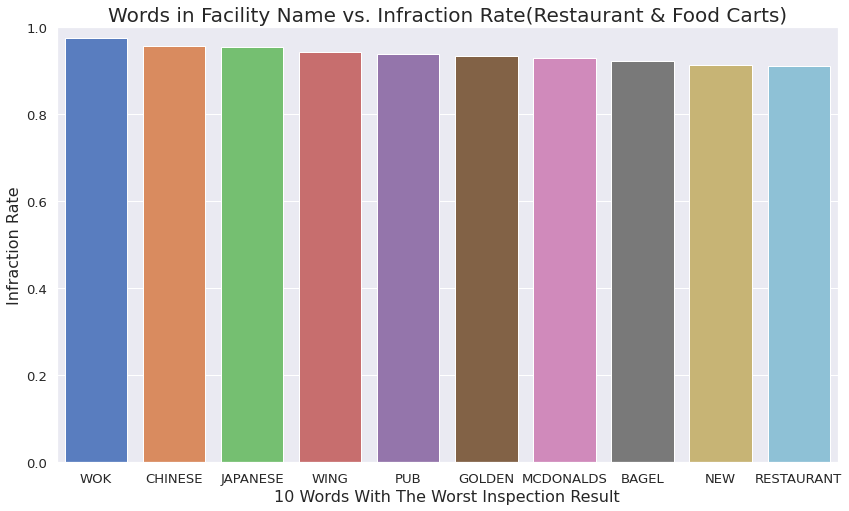

In [47]:
#Drop words in name that occured less than 30 times
all_words_rate_restaurant_final = all_words_restaurant_rate[all_words_restaurant_rate['NUM'] > 80]
all_words_rate_restaurant_final = all_words_rate_restaurant_final.sort_values(by='INFRACTION_RATE',ascending=False)
all_words_rate_restaurant_final.head(50)
#print(all_words_rate_final.shape[0])

fig, axs = plt.subplots(nrows=1, figsize=(14, 8))
sns.set(font_scale=1.2)
sns.barplot(
    x='WORD',
    y='INFRACTION_RATE',
    data=all_words_rate_restaurant_final.head(10),
    ci=None,
    palette = 'muted'
)
axs.set(ylim=(0, 1))
plt.xlabel('10 Words With The Worst Inspection Result', fontsize=16);
plt.ylabel('Infraction Rate', fontsize=16);
plt.title('Words in Facility Name vs. Infraction Rate(Restaurant & Food Carts)', fontsize=20)

Text(0.5, 1.0, 'Words in Facility Name vs. Infraction Rate (Restaurant & Food Carts)')

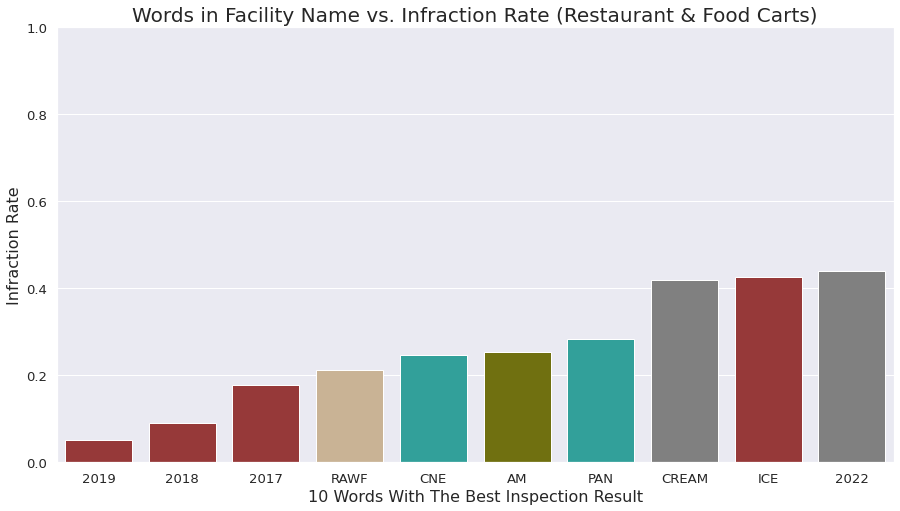

In [48]:
all_words_rate_restaurant_ascending = all_words_rate_restaurant_final.sort_values(by='INFRACTION_RATE',ascending=True)
all_words_rate_restaurant_ascending = all_words_rate_restaurant_ascending[all_words_rate_restaurant_ascending['INFRACTION_RATE']!=0]

fig, axs = plt.subplots(nrows=1, figsize=(15, 8))
sns.set(font_scale=1.2)


sns.barplot(
    x='WORD',
    y='INFRACTION_RATE',
    data=all_words_rate_restaurant_ascending.head(10),
    ci=None,
    palette = cls
)
axs.set(ylim=(0, 1))
plt.xlabel('10 Words With The Best Inspection Result', fontsize=16);
plt.ylabel('Infraction Rate', fontsize=16);
plt.title('Words in Facility Name vs. Infraction Rate (Restaurant & Food Carts)', fontsize=20)

Severity Analysis

In [49]:
def check_severity(df,id):
  df_of_id = df.loc[df.ESTABLISHMENT_ID == id] #All the inspection result of facility with establishment ID of "id"
  df_of_severity = df_of_id[ (df_of_id.SEVERITY == 'S - Significant') | (df_of_id.SEVERITY == 'C - Crucial')]
       
  if(df_of_severity.shape[0] == 0): #Nan means no sever infraction is observed
      return False
  return True

In [50]:
unique_facility_severity_result = unique_facility.copy()
unique_facility_severity_result['HIGH_SEVERITY'] = unique_facility_severity_result.apply(lambda row: check_severity(df_all,row.name), axis=1) 

In [51]:
word_split_with_severity = pd.merge(word_split,unique_facility_severity_result['HIGH_SEVERITY'],how='left',left_index=True,right_index=True)

In [52]:
# A function that takes a word as input and returns the infraction rate when that word is in a facilities' name
def severity_rate(df,word):
  all_with_word = df[df['WORD'] == word]
  total = all_with_word.shape[0] #This is the count of all the facilities having the word "word" in its name
  high_severity_count = all_with_word[all_with_word['HIGH_SEVERITY'] == True].shape[0] #This is the count of all the facilities having the word "word" in its name and have an infraction
  return high_severity_count/total

In [53]:
all_words_with_severity_rate = all_words.copy()
all_words_with_severity_rate['SEVERITY_RATE'] = all_words.apply(lambda row: severity_rate(word_split_with_severity,row.WORD), axis=1)
all_words_with_severity_rate['NUM'] = all_words_with_severity_rate.apply(lambda row: count_words(word_split_with_severity, row.WORD), axis=1)

In [54]:
all_words_with_severity_rate.head()

,NUM,WORD,SEVERITY_RATE
0,7,SAI,1.000000
1,1,LILA,1.000000
2,1,KHAMAN,1.000000
3,1,DHOKLA,1.000000
4,676,HOUSE,0.738166


Text(0.5, 1.0, 'High Severity Infraction & Words in Facility Name')

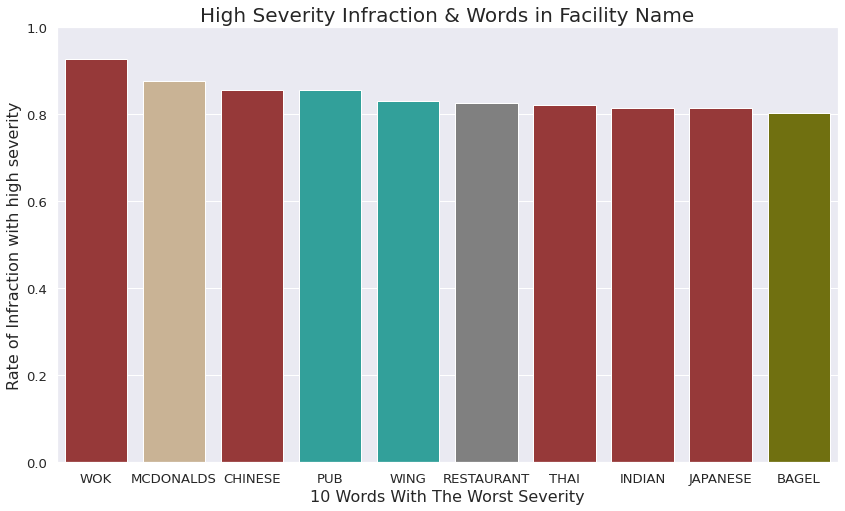

In [55]:
#Drop words in name that occured less than 100 times
all_words_rate_severity_final = all_words_with_severity_rate[all_words_with_severity_rate['NUM'] > 80]
all_words_rate_severity_final = all_words_rate_severity_final.sort_values(by='SEVERITY_RATE',ascending=False)
all_words_rate_severity_final.head(5)
#print(all_words_rate_final.shape[0])

fig, axs = plt.subplots(nrows=1, figsize=(14, 8))
sns.set(font_scale=1.2)
cls = ['brown','tan','brown','lightseagreen','lightseagreen','grey','brown','brown','brown','olive']
sns.barplot(
    x='WORD',
    y='SEVERITY_RATE',
    data=all_words_rate_severity_final.head(10),
    ci=None,
    palette = cls
)
axs.set(ylim=(0, 1))
plt.xlabel('10 Words With The Worst Severity', fontsize=16);
plt.ylabel('Rate of Infraction with high severity', fontsize=16);
plt.title('High Severity Infraction & Words in Facility Name', fontsize=20)